In [1]:
#Basic imports
%matplotlib inline
import importlib 
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RepeatedKFold
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from numba import cuda
import warnings

# Data Processing

In [164]:
# Import data
data2 = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)
data = pd.read_excel('data2.xlsx', 'Sheet1', header=0)

In [165]:
data['Date of birth'] = pd.to_datetime(data['Date of birth'].astype(str), format='%d/%m/%Y')
data['Date of MRI scan'] = pd.to_datetime(data['Date of MRI scan'].astype(str), format='%Y-%m-%d', errors='ignore')
data['Age'] = (data['Date of MRI scan'] - data['Date of birth'])/ np.timedelta64(1, 'Y')

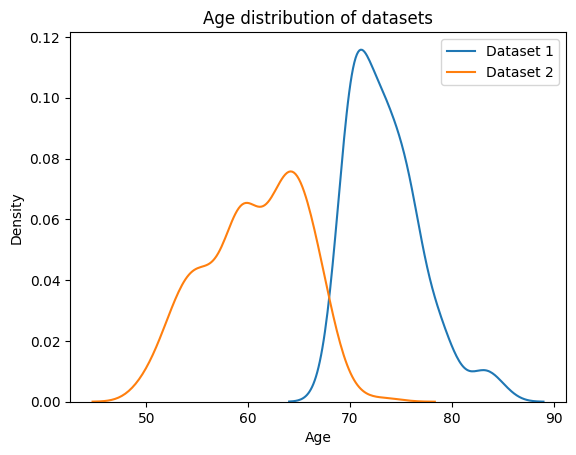

In [166]:
sns.kdeplot(
    data2,
    x='Age',
    label='Dataset 1'
).set_title("Age distribution of datasets")

sns.kdeplot(
    data,
    x='Age',
    label='Dataset 2'
)

plt.legend()
plt.show()

C:\Users\anton\AppData\Local\Temp\ipykernel_3092\4096845564.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


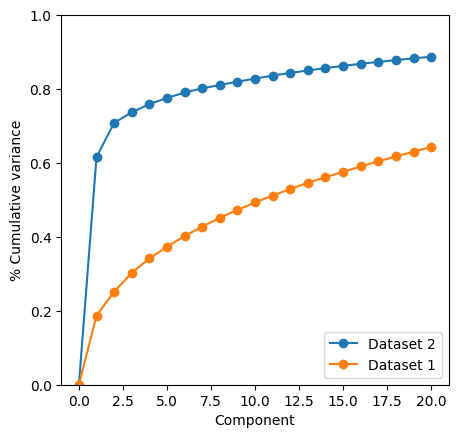

In [182]:
pca1 = PCA(n_components=20)
pca2 = PCA(n_components=20)
pca1.fit_transform(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pca2.fit_transform(x_train2.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

# Create figure
fig, axs = plt.subplots(1, 1)
n = pca1.n_components_
grid = np.arange(1, n + 1)

# Cumulative Variance
plt.ylim(0, 1)
cv1 = np.cumsum(pca1.explained_variance_ratio_)
cv2 = np.cumsum(pca2.explained_variance_ratio_)
plt.plot(np.r_[0, grid], np.r_[0, cv1], "o-", label='Dataset 2')
plt.plot(np.r_[0, grid], np.r_[0, cv2], "o-", label='Dataset 1')

# Set up figure
fig.set(figwidth=5, dpi=100)
plt.legend(loc=4)
plt.ylabel('% Cumulative variance')
plt.xlabel('Component')
fig.show()

In [179]:
cv1

array([0.61597382, 0.70846792, 0.73688654, 0.75936551, 0.77567028,
       0.79070473, 0.80170533, 0.81109371, 0.81987364, 0.82825518,
       0.83634571, 0.84359356, 0.85022771, 0.85668323, 0.86272468,
       0.8681878 , 0.87344483, 0.87828133, 0.88302018, 0.88738752])

In [178]:
cv2

array([0.1872881 , 0.2513304 , 0.30251242, 0.34153903, 0.37329664,
       0.40227455, 0.42760178, 0.45180167, 0.47283808, 0.49314036,
       0.51165753, 0.52987385, 0.54628513, 0.56147783, 0.57614947,
       0.59044646, 0.60447366, 0.6176809 , 0.6305422 , 0.64324415])

In [167]:
def clean_data(df, i_dataset, del_col=[], mean=[], std=[]):
    X = df.copy()
    
    # Remove useless columns
    if (i_dataset == 1):
        X = X.drop(['Patient ID', 'Batch Process ID'], axis=1)
    elif (i_dataset == 2):
        X = X.drop(['Subject ID', 'Date of birth', 'Date of MRI scan'], axis=1)
    
    # Remove columns with only zeros
    if (len(del_col) == 0):
        del_col = (X != 0).any(axis=0)
    X = X.loc[:, del_col]
    
    # Replace zeros by nan
    X.replace(0, np.nan, inplace=True)
    
    # Replace Sex labels by values
    if (i_dataset == 1):
        X['Sex'].replace({'Male':1,'Female':2}, inplace=True)
        X = X.rename(columns={"Sex": "Gender"})
    
    # Categorical values
    cater = X[['Gender']]
    
    # Numerical values
    numer = X.drop(['Gender'], axis=1)
    
    # Replace nan values by mean of column
    if (len(mean) == 0 or len(std) == 0):
        mean = numer.mean()
        std = numer.std()
        std = std.fillna( 1)
    numer = numer.fillna(mean)
                 
    
    #Scale each column in numer
    numer = (numer - mean)/std
    
    new_X = pd.concat([numer, cater], axis=1, join='inner')
    
    return new_X, del_col, mean, std

In [168]:
data_train, data_test, y_train, y_test = train_test_split(data.drop(['Age'], axis=1), data['Age'], test_size=0.3, random_state=2)

In [169]:
y_train = pd.DataFrame(data=y_train, columns=['Age']).reset_index(drop=True)
y_test = pd.DataFrame(data=y_test, columns=['Age']).reset_index(drop=True)

In [170]:
x_train, del_col, mean_train, std_train = clean_data(data_train, 2)
x_test, _, _, _ = clean_data(data_test, 2, del_col, mean_train, std_train)

In [171]:
data_train2, data_test2, y_train2, y_test2 = train_test_split(data2.drop(['Age'], axis=1), data2['Age'], test_size=0.3, random_state=2)

In [172]:
y_train2 = pd.DataFrame(data=y_train2, columns=['Age']).reset_index(drop=True)
y_test2 = pd.DataFrame(data=y_test2, columns=['Age']).reset_index(drop=True)

In [173]:
x_train2, del_col2, mean_train2, std_train2 = clean_data(data_train2, 1)
x_test2, _, _, _ = clean_data(data_test2, 1, del_col2, mean_train2, std_train2)

In [10]:
def predict(model, x_train, x_test):
    predict_train = model.predict(x_train)
    predict_test = model.predict(x_test)
    
    return predict_train, predict_test

In [11]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [12]:
def compute_mae(y_train, y_test, predict_train, predict_test):
    train_mae = mean_absolute_error(y_train, predict_train)
    test_mae = mean_absolute_error(y_test, predict_test)
    
    return train_mae, test_mae

In [13]:
def compute_r2(y_train, y_test, predict_train, predict_test):
    train_r2 = r2_score(y_train, predict_train)
    test_r2 = r2_score(y_test, predict_test)
    
    return train_r2, test_r2

In [14]:
def plot_results(title, x_train, x_test, predict_train, predict_test):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.set_xlabel('True Age', fontsize = 15)
    ax1.set_ylabel('Predicted Age', fontsize = 15)
    ax1.set_title(title + ' - Train')
    ax2.set_xlabel('True Age', fontsize = 15)
    ax2.set_title(title + ' - Test')

    targets = [0, 1, 2]
    colors = ['r', 'g', 'b']
    for target, color in zip(targets, colors):
        idx_train = np.where(x_train['Cluster'] == target)
        idx_test = np.where(x_test['Cluster'] == target)
        ax1.scatter(y_train.iloc[idx_train],
                    predict_train[idx_train],
                   c = color, 
                   s = 50)
        ax2.scatter(y_test.iloc[idx_test],
                    predict_test[idx_test],
                   c = color, 
                   s = 50)
    ax1.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    ax1.grid()
    ax2.legend(['Cluster 0', 'Cluster 1', 'Cluster 2'])
    ax2.grid()

    p1 = max(max(predict_train), max(np.array(y_train)))
    p2 = min(min(predict_train), min(np.array(y_train)))
    ax1.plot([p1, p2], [p1, p2], 'b-')
    ax2.plot([p1, p2], [p1, p2], 'b-')

### Model

In [15]:
def model_gs(model, param_grid): 
    
    cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=42)
    
    # Construct pipeline
    pipe = Pipeline([
        ('clf', model)
    ])
    
    # Construct grid search
    gs = GridSearchCV(estimator=pipe,
        param_grid=param_grid,
        scoring='r2',
        cv=cv, verbose=10, n_jobs=-1, return_train_score = True)
    
    return gs


In [16]:
from sklearn import svm
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Create grids for search parameters
param_grid_svm = [
    {'clf__C': np.logspace(-3, 3, 10), 'clf__kernel': ['linear']},
    {'clf__C': np.logspace(-3, 3, 10), 'clf__gamma': np.logspace(-10, 0, 20), 'clf__kernel': ['rbf']},
]

param_grid_elastic = {
    'clf__alpha': np.logspace(-10,7,25),
    'clf__l1_ratio': np.append(np.logspace(-10,0,20), 0)
}

param_grid_adaboost = {
    'clf__n_estimators': np.arange(1, 200, 20),
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

param_grid_forest = {
    'clf__n_estimators': np.arange(10, 100, 20),
    'clf__max_depth': np.arange(1, 20)
}

param_grid_knn = {
    'clf__n_neighbors': np.arange(1, 20)
}


# Create models grid search
model_svr = model_gs(
    svm.SVR(),
    param_grid_svm
)

model_elastic = model_gs(
    ElasticNet(max_iter=5000),
    param_grid_elastic
)

model_adaboost = model_gs(
    AdaBoostRegressor(random_state = 123),
    param_grid_adaboost
)

model_forest = model_gs(
    RandomForestRegressor(),
    param_grid_forest
)

model_knn = model_gs(
    KNeighborsRegressor(),
    param_grid_knn
)

# Create models list
models = {
    "SVR": model_svr,
    "ElasticNet": model_elastic,
    "AdaBoost": model_adaboost,
    "RandomForest": model_forest,
    "KNN": model_knn
}


In [17]:
def train_model(title, gs, x_train, x_test, y_train, y_test):
    
    # Fit using grid search
    gs.fit(x_train.drop(['Cluster'], axis=1, errors='ignore'), y_train['Age'])

    # Compute predictions
    predict_train, predict_test = predict(
        gs.best_estimator_,
        x_train.drop(['Cluster'], axis=1, errors='ignore'),
        x_test.drop(['Cluster'], axis=1, errors='ignore')
    )
      
    # Compute MAE and R2 scores
    train_mae, test_mae = compute_mae(y_train['Age'], y_test['Age'], predict_train, predict_test)
    train_r2, test_r2 = compute_r2(y_train['Age'], y_test['Age'], predict_train, predict_test)
    
    plot_results(title, x_train, x_test, predict_train, predict_test)

    return gs.best_score_, train_r2, test_r2, train_mae, test_mae
    

# PLS

In [18]:
from sklearn.cross_decomposition import PLSRegression

In [19]:
# PLS Regression
n_components = 20
pls = PLSRegression(n_components=n_components)
pls.fit(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'), y_train)

new_x_train = pls.transform(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
new_x_test = pls.transform(x_test.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pls_train = pd.DataFrame(data = new_x_train, columns = ["class%02d" %i for i in range(1,n_components+1)])
pls_test = pd.DataFrame(data = new_x_test, columns = ["class%02d" %i for i in range(1,n_components+1)])

### Standardize

In [20]:
train_mean = np.mean(pls_train, axis=0)
train_std = np.std(pls_test, axis=0)

pls_train_scaled = (pls_train - train_mean)/train_std
pls_test_scaled = (pls_test - train_mean)/train_std

### Clustering

In [113]:
kmeanModel = KMeans(n_clusters=4).fit(pls_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

pls_train_scaled['Cluster'] = kmeanModel.labels_
pls_test_scaled['Cluster'] = kmeanModel.predict(pls_test_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [95]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(pls_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

# Assign train samples to clusters
pls_train_scaled['Cluster'] = gmm.predict(pls_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pls_test_scaled['Cluster'] =gmm.predict(pls_test_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

C:\Users\anton\AppData\Local\Temp\ipykernel_3092\424489776.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.displot(


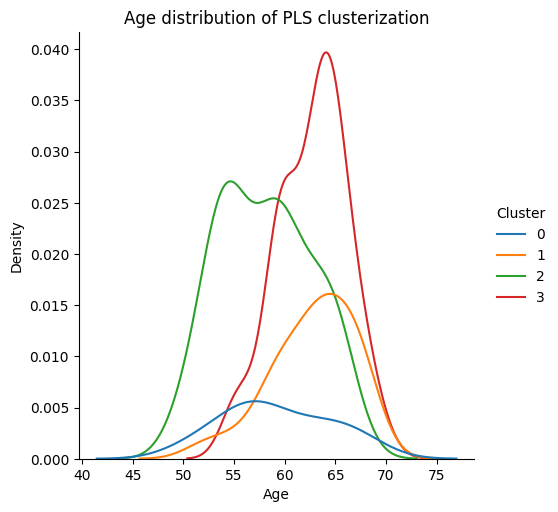

In [114]:
sns.displot(
    pd.concat([y_train, pls_train_scaled], axis=1, join='inner'),
    x='Age',
    hue='Cluster',
    kind='kde',
    palette=sns.color_palette("tab10")
).set(title='Age distribution of PLS clusterization')

plt.show()

### Filter MI Score

In [85]:
mi_score_train = make_mi_scores(pls_train_scaled.drop(['Cluster'], axis=1, errors='ignore'), y_train['Age'])

keep_pls = (mi_score_train[mi_score_train > 0].index.to_list())

keep_pls.append('Cluster')

pls_train_scaled = pls_train_scaled[keep_pls]
pls_test_scaled = pls_test_scaled[keep_pls]

### Test for global

In [88]:
print(f'-- Global --')
print(f'training_samples = {y_train.shape[0]}')
print(f'testing_samples = {y_test.shape[0]}')

-- Global --
training_samples = 162
testing_samples = 70


Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e+02, tolerance: 3.545e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


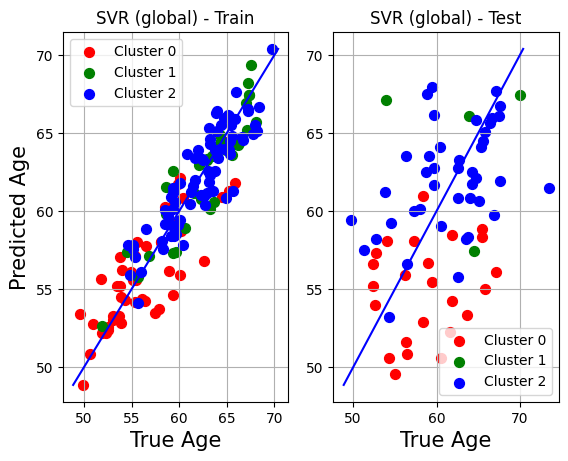

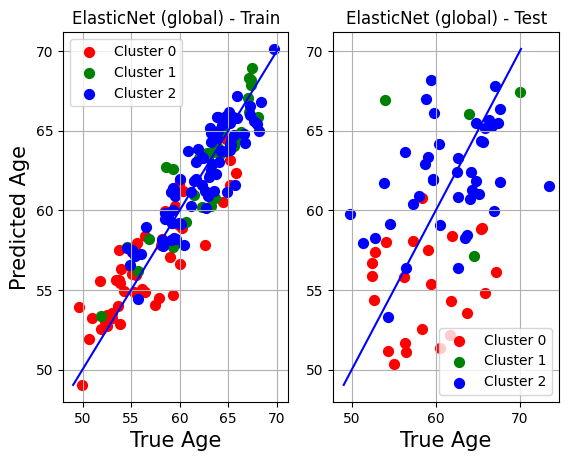

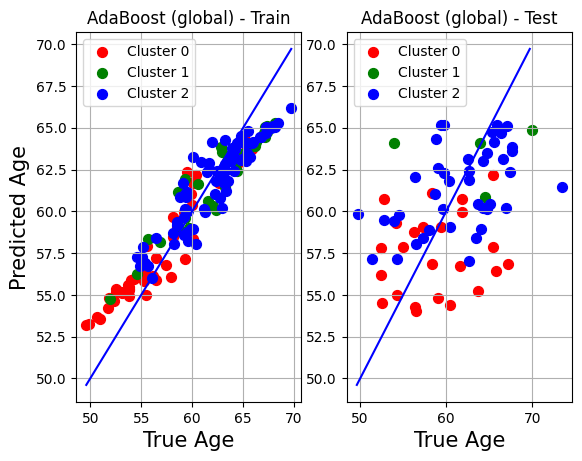

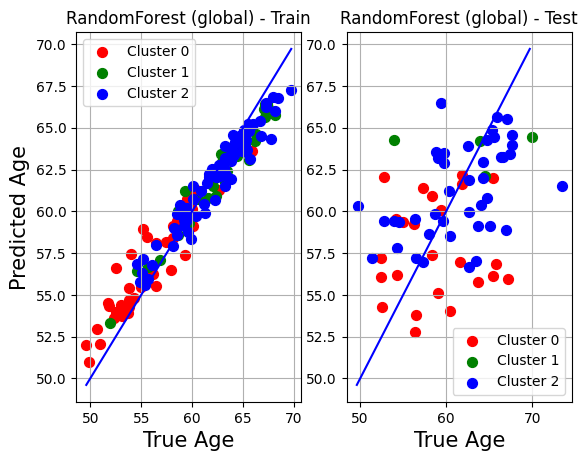

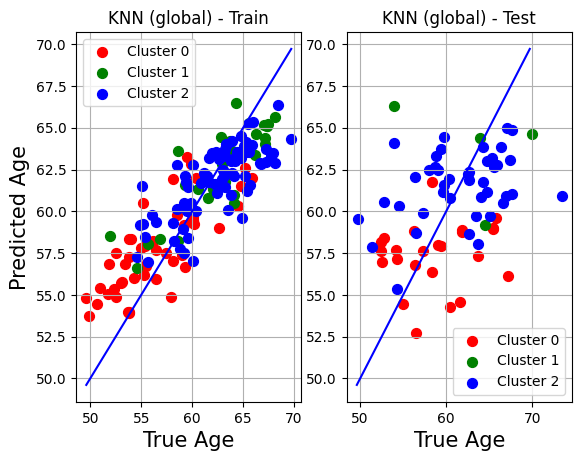

In [89]:
#Create DataFrame for the results
results_pls_global = pd.DataFrame(columns=["Best score", "Train R2",  "Test R2", "Train MAE", "Test MAE"])

#Test for each model
for model_name in models:
    results_pls_global.loc[model_name] = train_model(
        model_name + ' (global)',
        models[model_name],
        pls_train_scaled,
        pls_test_scaled,
        y_train,
        y_test
    )
    
results_pls_global = results_pls_global.style.set_caption('Global')

### Test for each cluster

In [90]:
#Create DataFrames for the results
results_pls_cluster_0 = pd.DataFrame(columns=["Best score", "Train R2",  "Test R2", "Train MAE", "Test MAE"])
results_pls_cluster_1 = pd.DataFrame(columns=["Best score", "Train R2",  "Test R2", "Train MAE", "Test MAE"])
results_pls_cluster_2 = pd.DataFrame(columns=["Best score", "Train R2",  "Test R2", "Train MAE", "Test MAE"])

#### Cluster 0

In [91]:
#Init DataFrame for Cluster 0
idx_train_0 = np.where(pls_train_scaled["Cluster"]==0)
x_train_cluster_0 = pls_train_scaled.iloc[idx_train_0]
y_train_cluster_0 = y_train.iloc[idx_train_0]

idx_test_0 = np.where(pls_test_scaled["Cluster"]==0)
x_test_cluster_0 = pls_test_scaled.iloc[idx_test_0]
y_test_cluster_0 = y_test.iloc[idx_test_0]

print(f'-- Cluster 0 --')
print(f'training_samples = {y_train_cluster_0.shape[0]} ({y_train_cluster_0.shape[0]/y_train.shape[0]*100:.2f}%)')
print(f'testing_samples = {y_test_cluster_0.shape[0]} ({y_test_cluster_0.shape[0]/y_test.shape[0]*100:.2f}%)')

-- Cluster 0 --
training_samples = 49 (30.25%)
testing_samples = 24 (34.29%)


Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.548e+02, tolerance: 8.687e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


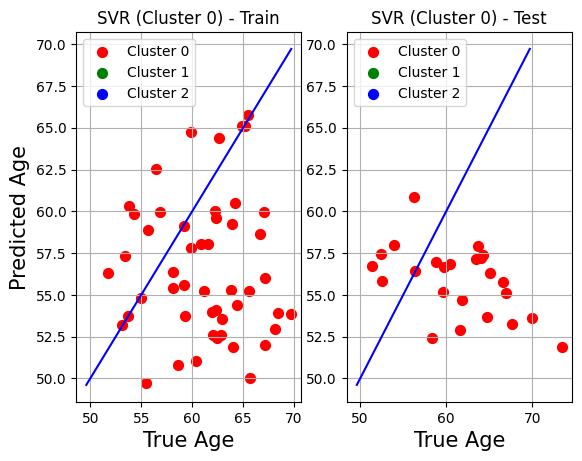

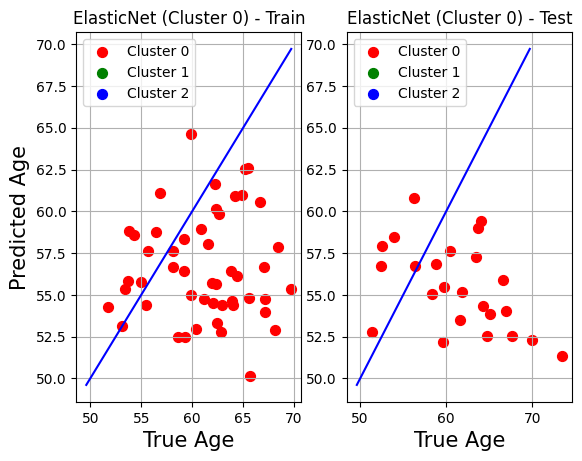

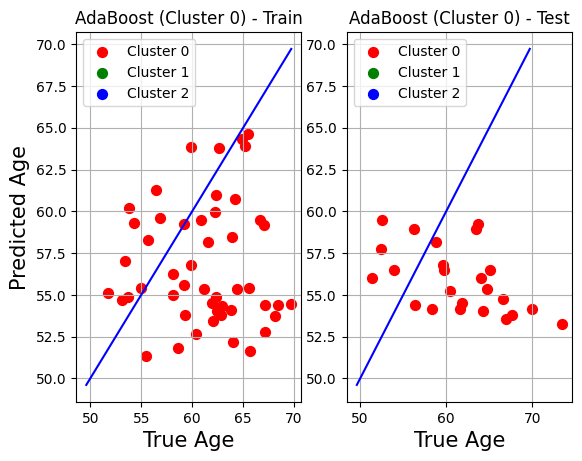

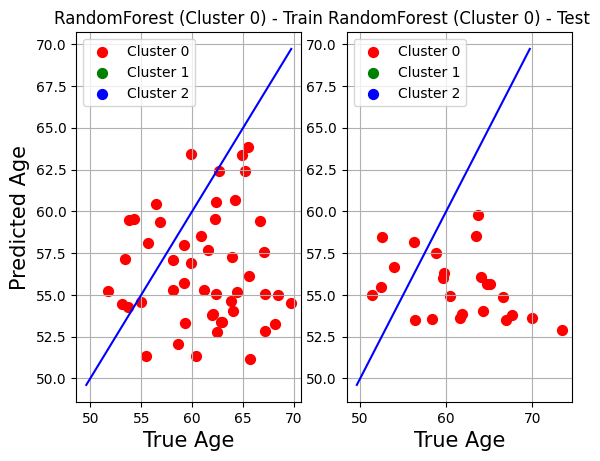

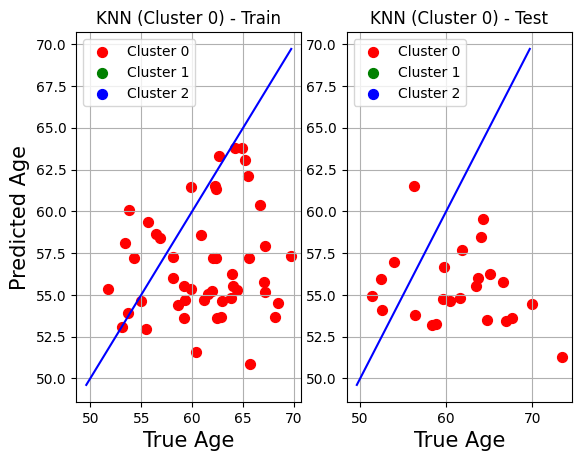

In [92]:
#Test for each model
for model_name in models:
    results_pls_cluster_0.loc[model_name] = train_model(
        model_name + ' (Cluster 0)',
        models[model_name],
        x_train_cluster_0,
        x_test_cluster_0,
        y_train_cluster_0,
        y_test_cluster_0
    )
    
results_pls_cluster_0 = results_pls_cluster_0.style.set_caption('Cluster 0')

#### Cluster 1

In [93]:
#Init DataFrame for Cluster 1
idx_train_1 = np.where(pls_train_scaled["Cluster"]==1)
x_train_cluster_1 = pls_train_scaled.iloc[idx_train_1]
y_train_cluster_1 = y_train.iloc[idx_train_1]

idx_test_1 = np.where(pls_test_scaled["Cluster"]==1)
x_test_cluster_1 = pls_test_scaled.iloc[idx_test_1]
y_test_cluster_1 = y_test.iloc[idx_test_1]

print(f'-- Cluster 1 --')
print(f'training_samples = {y_train_cluster_1.shape[0]} ({y_train_cluster_1.shape[0]/y_train.shape[0]*100:.2f}%)')
print(f'testing_samples = {y_test_cluster_1.shape[0]} ({y_test_cluster_1.shape[0]/y_test.shape[0]*100:.2f}%)')

-- Cluster 1 --
training_samples = 34 (20.99%)
testing_samples = 4 (5.71%)


Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.423e+01, tolerance: 5.413e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


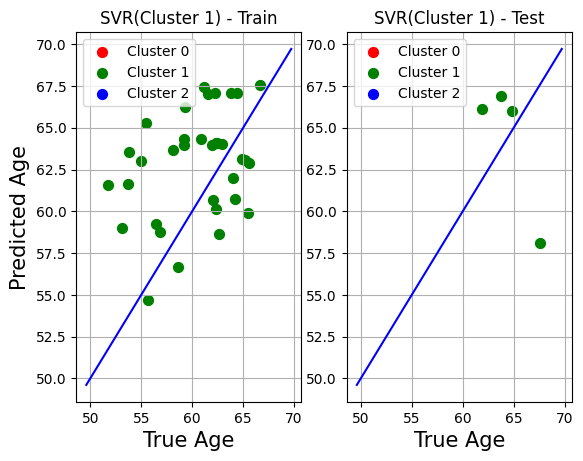

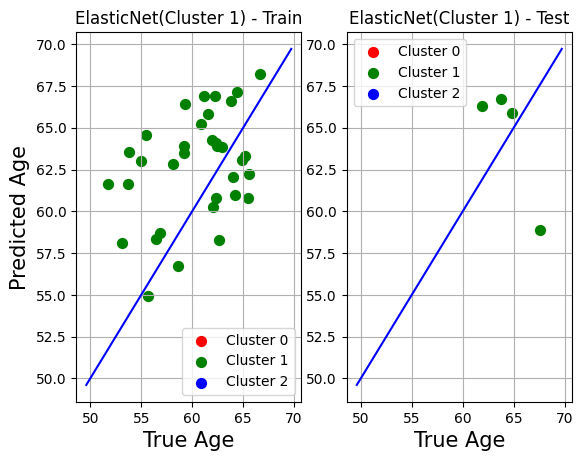

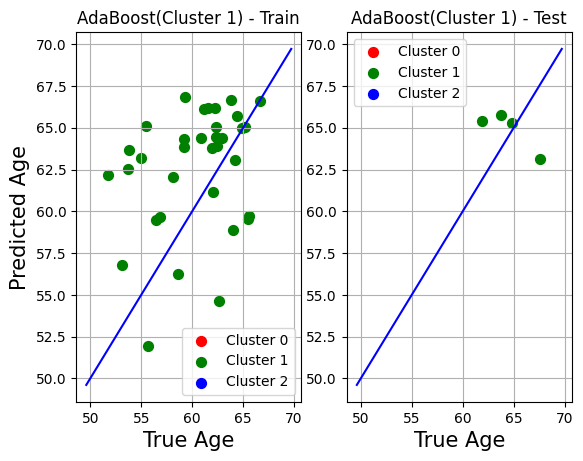

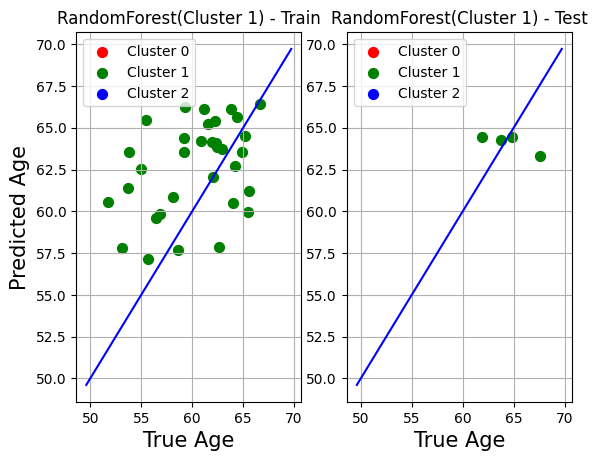

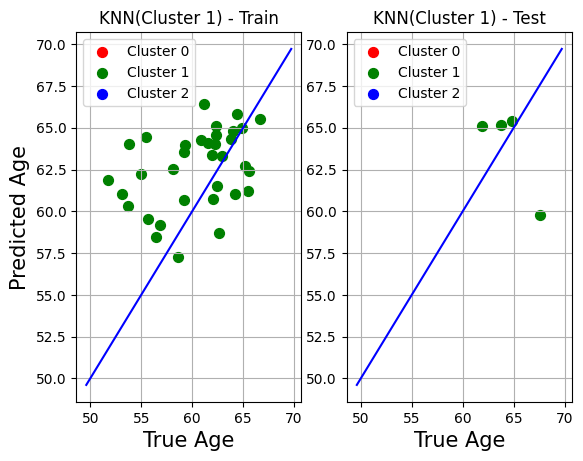

In [94]:
#Test for each model
for model_name in models:
    results_pls_cluster_1.loc[model_name] = train_model(
        model_name + '(Cluster 1)',
        models[model_name],
        x_train_cluster_1,
        x_test_cluster_1,
        y_train_cluster_1,
        y_test_cluster_1
    )

results_pls_cluster_1 = results_pls_cluster_1.style.set_caption('Cluster 1')

#### Cluster 2

In [95]:
#Init DataFrame for Cluster 2
idx_train_2 = np.where(pls_train_scaled["Cluster"]==2)
x_train_cluster_2 = pls_train_scaled.iloc[idx_train_2]
y_train_cluster_2 = y_train.iloc[idx_train_2]

idx_test_2 = np.where(pls_test_scaled["Cluster"]==2)
x_test_cluster_2 = pls_test_scaled.iloc[idx_test_2]
y_test_cluster_2 = y_test.iloc[idx_test_2]

print(f'-- Cluster 2 --')
print(f'training_samples = {y_train_cluster_2.shape[0]} ({y_train_cluster_2.shape[0]/y_train.shape[0]*100:.2f}%)')
print(f'testing_samples = {y_test_cluster_2.shape[0]} ({y_test_cluster_2.shape[0]/y_test.shape[0]*100:.2f}%)')

-- Cluster 2 --
training_samples = 79 (48.77%)
testing_samples = 42 (60.00%)


Fitting 15 folds for each of 210 candidates, totalling 3150 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.123e+02, tolerance: 1.004e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


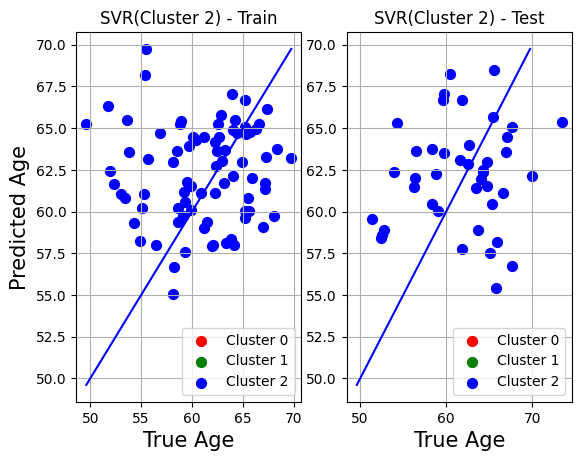

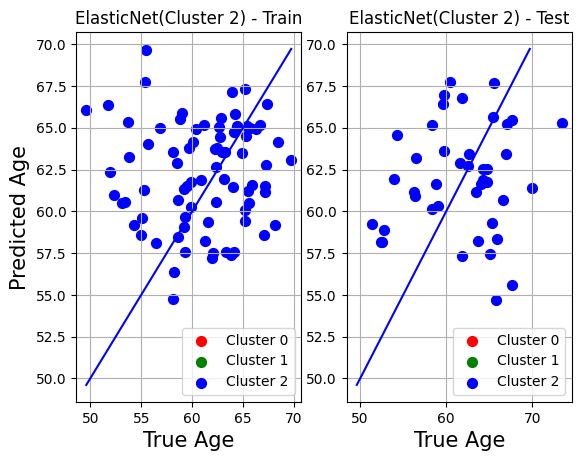

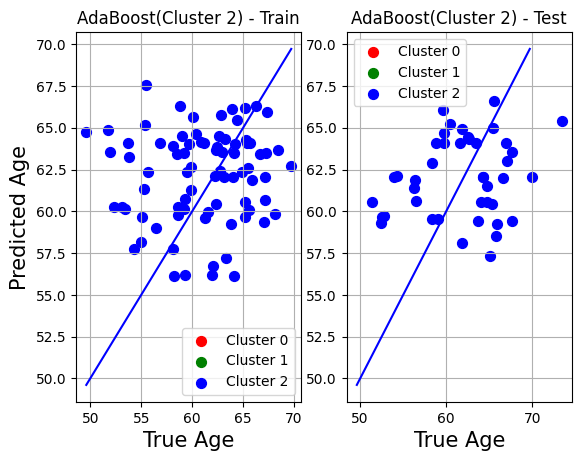

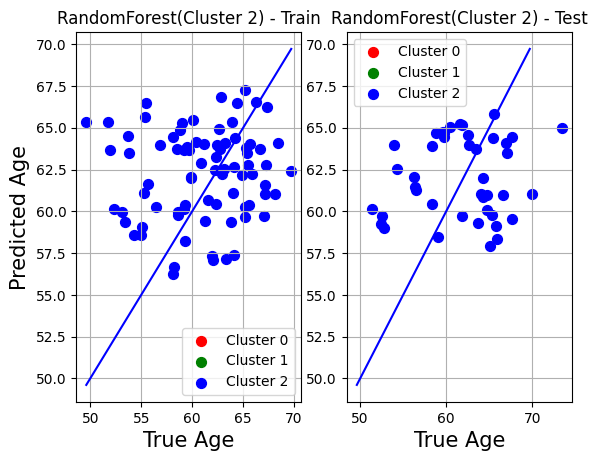

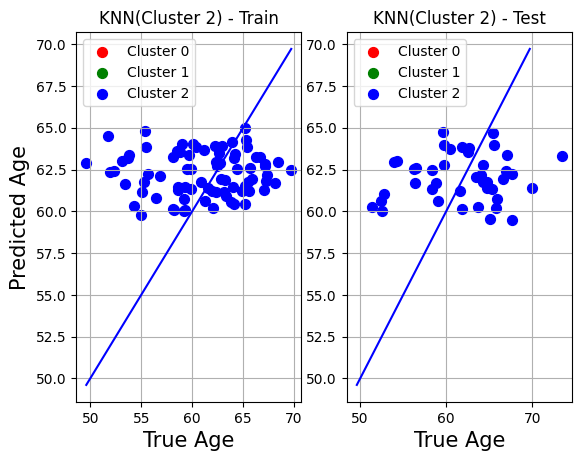

In [96]:
#Test for each model
for model_name in models:
    results_pls_cluster_2.loc[model_name] = train_model(
        model_name + '(Cluster 2)',
        models[model_name],
        x_train_cluster_2,
        x_test_cluster_2,
        y_train_cluster_2,
        y_test_cluster_2
    )

results_pls_cluster_2 = results_pls_cluster_2.style.set_caption('Cluster 2')

###### With keep PLS but clustering after filtering

In [97]:
results_pls_global

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.804236,0.841526,-0.126236,1.454522,4.426412
ElasticNet,0.819152,0.848221,-0.119228,1.492026,4.433132
AdaBoost,0.535858,0.856245,0.157754,1.553489,3.849299
RandomForest,0.503055,0.925520,0.109582,1.004182,3.891074
KNN,0.594625,0.696073,0.068921,2.086937,4.106235


In [98]:
results_pls_cluster_0

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.463594,0.999446,-0.569314,0.098537,4.552045
ElasticNet,0.477393,0.735599,-0.671880,1.756091,4.901411
AdaBoost,0.280969,0.943692,-0.777915,0.846572,4.830658
RandomForest,0.265787,0.918415,-0.782410,0.985350,4.734609
KNN,0.325235,0.702129,-0.654590,1.894688,4.687107


In [99]:
results_pls_cluster_1

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.534545,0.819067,-0.517756,1.164646,5.931151
ElasticNet,0.537817,0.832097,-0.490352,1.274540,5.813859
AdaBoost,0.008387,0.968527,-0.140571,0.531834,4.592164
RandomForest,0.035426,0.840665,-0.080094,1.200041,4.495392
KNN,0.179934,0.553393,-0.283280,2.040224,5.537143


In [100]:
results_pls_cluster_2

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.633704,0.786711,0.112010,1.270441,3.822215
ElasticNet,0.685117,0.809951,0.150923,1.312268,3.723035
AdaBoost,0.271022,0.906045,0.221561,0.935712,3.680933
RandomForest,0.279883,0.882644,0.253338,0.932585,3.640093
KNN,0.251008,0.388773,0.148434,2.260821,3.938449


###### Without keep PLS

In [80]:
results_pls_global

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.912824,0.938464,-0.572633,0.858144,5.080566
ElasticNet,0.913147,0.938189,-0.538155,0.920975,5.057238
AdaBoost,0.500537,0.859339,0.173462,1.548765,3.815389
RandomForest,0.451559,0.928035,0.127666,1.027280,3.964695
KNN,0.534469,0.672355,0.004052,2.226256,4.188545


In [81]:
results_pls_cluster_0

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.749956,0.982784,-0.193926,0.239744,4.382552
ElasticNet,0.771605,0.924765,-0.282479,0.793562,4.526228
AdaBoost,0.352055,0.939233,0.068157,0.741558,4.053021
RandomForest,0.361872,0.926533,0.095863,0.790109,4.060499
KNN,0.370357,0.638272,-0.007541,1.841644,4.086560


In [82]:
results_pls_cluster_1

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.825060,0.964246,-0.873375,0.518527,5.662883
ElasticNet,0.826088,0.938852,-1.035705,0.943224,5.926155
AdaBoost,0.158686,0.923280,-0.037043,1.080090,4.160873
RandomForest,0.151110,0.899559,-0.001081,1.234418,4.158095
KNN,0.309659,0.577223,-0.025952,2.600783,4.267346


In [83]:
results_pls_cluster_2

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.432772,0.999379,-0.916446,0.100163,5.768013
ElasticNet,0.462332,0.965066,-0.806860,0.636164,5.791232
AdaBoost,-0.194216,0.971856,0.154924,0.525326,3.409343
RandomForest,-0.052268,0.874653,0.068677,1.089754,3.920318
KNN,0.093602,0.447675,-0.089318,2.428067,4.579454


###### With keep PLS, filtering after clustering

In [61]:
results_pls_global

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.804236,0.841526,-0.126236,1.454522,4.426412
ElasticNet,0.819152,0.848221,-0.119228,1.492026,4.433132
AdaBoost,0.535858,0.856245,0.157754,1.553489,3.849299
RandomForest,0.502127,0.932800,0.116027,0.961161,3.903598
KNN,0.594625,0.696073,0.068921,2.086937,4.106235


In [62]:
results_pls_cluster_0

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.445202,0.982317,0.025624,0.255520,4.132830
ElasticNet,0.514200,0.751701,-0.169851,1.632880,4.868558
AdaBoost,0.176351,0.922548,-0.206006,0.962299,4.592714
RandomForest,0.172889,0.887008,-0.202473,1.084263,4.575386
KNN,0.318530,0.602959,-0.221343,2.036042,4.818858


In [63]:
results_pls_cluster_1

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.354340,0.999418,-0.607993,0.100085,5.697273
ElasticNet,0.551526,0.882565,-0.555618,1.171892,5.363481
AdaBoost,-0.170871,0.944994,0.009455,0.740085,3.950663
RandomForest,-0.058435,0.869788,0.011007,1.150898,4.260621
KNN,0.186920,0.629582,-0.553505,1.825407,6.201907


In [64]:
results_pls_cluster_2

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.619103,0.756418,-0.171521,1.240349,3.961952
ElasticNet,0.642192,0.770971,-0.229389,1.281719,4.021289
AdaBoost,0.273895,0.889195,-0.130718,0.985257,3.964904
RandomForest,0.275661,0.896135,-0.115085,0.886692,3.886012
KNN,0.239800,0.428457,0.028121,1.972907,3.678626


# PCA

In [33]:
from sklearn.decomposition import PCA

C:\Users\anton\AppData\Local\Temp\ipykernel_3092\3546841399.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


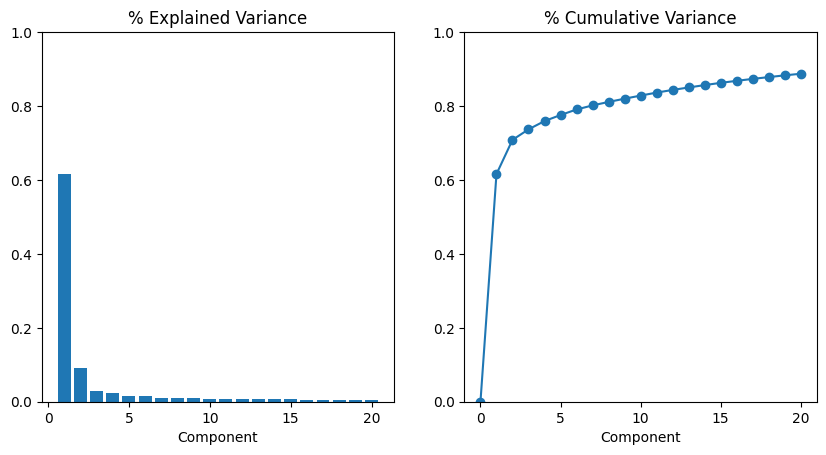

In [177]:
pca = PCA(n_components=20)
pc = pca.fit_transform(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pc_train = pd.DataFrame(data = pc, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])
pc_test = pca.transform(x_test.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pc_test = pd.DataFrame(data = pc_test, columns = ["PC%02d" %i for i in range(1,pca.n_components_+1)])

# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
evr = pca.explained_variance_ratio_
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title=f"% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
cv = np.cumsum(evr)
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].set(
    xlabel="Component", title=f"% Cumulative Variance", ylim=(0.0, 1.0)
)

# Set up figure
fig.set(figwidth=10, dpi=100)
fig.show()

### Standardize

In [35]:
train_mean = np.mean(pc_train, axis=0)
train_std = np.std(pc_train, axis=0)

pc_train_scaled = (pc_train - train_mean)/train_std
pc_test_scaled = (pc_test - train_mean)/train_std

### Clustering

In [111]:
kmeanModel = KMeans(n_clusters=4).fit(pc_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

pc_train_scaled['Cluster'] = kmeanModel.labels_
pc_test_scaled['Cluster'] = kmeanModel.predict(pc_test_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [97]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(pc_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

# Assign train samples to clusters
pc_train_scaled['Cluster'] = gmm.predict(pc_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
pc_test_scaled['Cluster'] =gmm.predict(pc_test_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

C:\Users\anton\AppData\Local\Temp\ipykernel_3092\2412220399.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.displot(


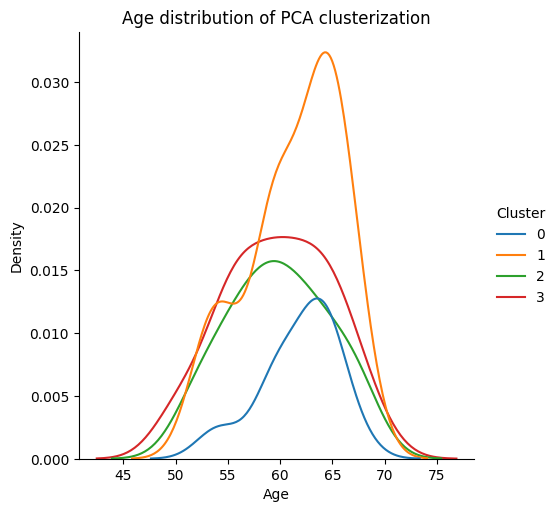

In [112]:
sns.displot(
    pd.concat([y_train, pc_train_scaled], axis=1, join='inner'),
    x='Age',
    hue='Cluster',
    kind='kde',
    palette=sns.color_palette("tab10")
).set(title='Age distribution of PCA clusterization')

plt.show()

### Filter MI Score

After testing, keeping only PC with MI Score > 0 didn't improve the results (slightly worse in fact)

### Test Model for each cluster

In [ ]:
#Init DataFrame for Cluster 0
cluster_tr = pc_train_scaled.iloc[np.where(pc_train_scaled["Cluster"]==0)]
train_cluster = cluster_tr.drop(['Cluster'], axis=1, errors='ignore')
y_train_cluster = y_train.iloc[np.where(pc_train_scaled["Cluster"]==0)]

cluster_te = pc_test_scaled.iloc[np.where(pc_test_scaled["Cluster"]==0)]
test_cluster = cluster_te.drop(['Cluster'], axis=1, errors='ignore')
y_test_cluster = y_test.iloc[np.where(pc_test_scaled["Cluster"]==0)]

#Create DataFrame for the result
df_pca_0 = pd.DataFrame(columns=["Best score", "Train r2",  "Test r2", "Train mae", "Test mae"])


#Test for each model
df_pca_0.loc["SVR"] = svr_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0.loc["Elastic Net"] = elastic_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0.loc["Adaboost"] = adaboost_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0.loc["Random Forest"] = random_forest_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0.loc["KNN"] = knn_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_0

In [ ]:
#Init DataFrame for Cluster 1
cluster_tr = pc_train_scaled.iloc[np.where(pc_train_scaled["Cluster"]==1)]
train_cluster = cluster_tr.drop(['Cluster'], axis=1, errors='ignore')
y_train_cluster = y_train.iloc[np.where(pc_train_scaled["Cluster"]==1)]

cluster_te = pc_test_scaled.iloc[np.where(pc_test_scaled["Cluster"]==1)]
test_cluster = cluster_te.drop(['Cluster'], axis=1, errors='ignore')
y_test_cluster = y_test.iloc[np.where(pc_test_scaled["Cluster"]==1)]

#Create DataFrame for the result
df_pca_1 = pd.DataFrame(columns=["Best score", "Train r2",  "Test r2", "Train mae", "Test mae"])


#Test for each model
df_pca_1.loc["SVR"] = svr_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1.loc["Elastic Net"] = elastic_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1.loc["Adaboost"] = adaboost_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1.loc["Random Forest"] = random_forest_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1.loc["KNN"] = knn_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_1

In [ ]:
#Init DataFrame for Cluster 2
cluster_tr = pc_train_scaled.iloc[np.where(pc_train_scaled["Cluster"]==2)]
train_cluster = cluster_tr.drop(['Cluster'], axis=1, errors='ignore')
y_train_cluster = y_train.iloc[np.where(pc_train_scaled["Cluster"]==2)]

cluster_te = pc_test_scaled.iloc[np.where(pc_test_scaled["Cluster"]==2)]
test_cluster = cluster_te.drop(['Cluster'], axis=1, errors='ignore')
y_test_cluster = y_test.iloc[np.where(pc_test_scaled["Cluster"]==2)]

#Create DataFrame for the result
df_pca_2 = pd.DataFrame(columns=["Best score", "Train r2",  "Test r2", "Train mae", "Test mae"])


#Test for each model
df_pca_2.loc["SVR"] = svr_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2.loc["Elastic Net"] = elastic_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2.loc["Adaboost"] = adaboost_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2.loc["Random Forest"] = random_forest_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2.loc["KNN"] = knn_model(train_cluster, test_cluster, y_train_cluster, y_test_cluster)
df_pca_2

# Raw

### Clustering

In [109]:
raw_train_scaled = x_train.copy()
raw_test_scaled = x_test.copy()

kmeanModel = KMeans(n_clusters=4).fit(x_train.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

raw_train_scaled['Cluster'] = kmeanModel.labels_
raw_test_scaled['Cluster'] = kmeanModel.predict(x_test.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [99]:
from sklearn.mixture import GaussianMixture
raw_train_scaled = x_train.copy()
raw_test_scaled = x_test.copy()

gmm = GaussianMixture(n_components=4).fit(raw_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

# Assign train samples to clusters
raw_train_scaled['Cluster'] = gmm.predict(raw_train_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))
raw_test_scaled['Cluster'] =gmm.predict(raw_test_scaled.drop(['Gender', 'Cluster'], axis=1, errors='ignore'))

C:\Users\anton\AppData\Local\Temp\ipykernel_3092\3631159683.py:1: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.displot(


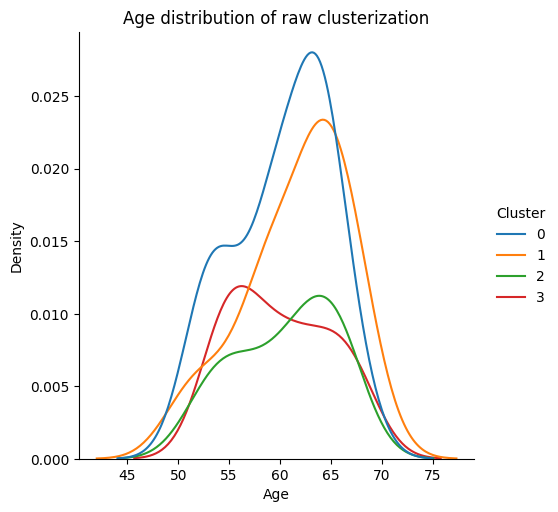

In [110]:
sns.displot(
    pd.concat([y_train, raw_train_scaled], axis=1, join='inner'),
    x='Age',
    hue='Cluster',
    kind='kde',
    palette=sns.color_palette("tab10")
).set(title='Age distribution of raw clusterization')

plt.show()

### Test for global model

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+03, tolerance: 3.545e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


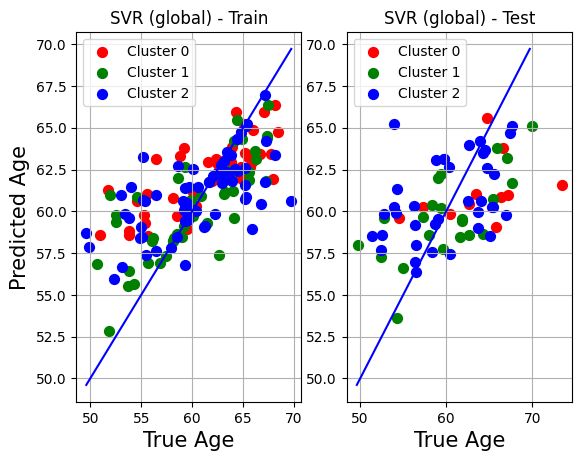

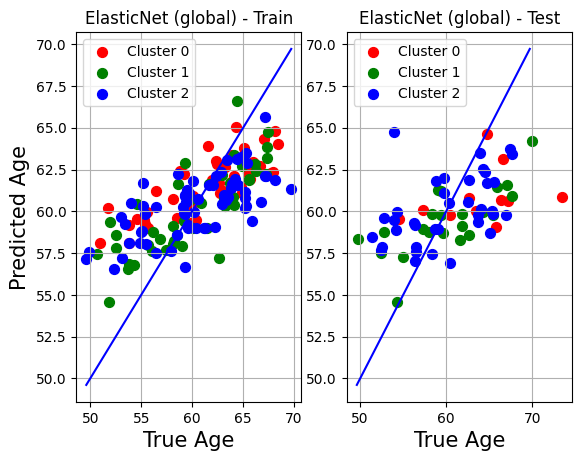

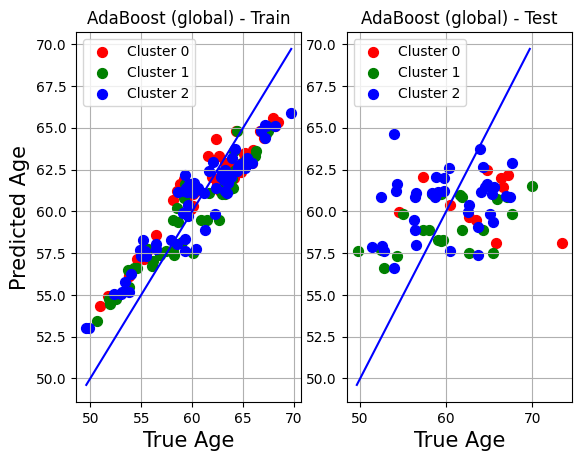

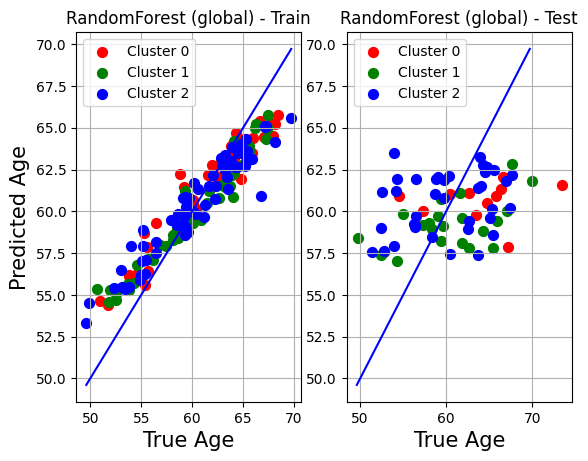

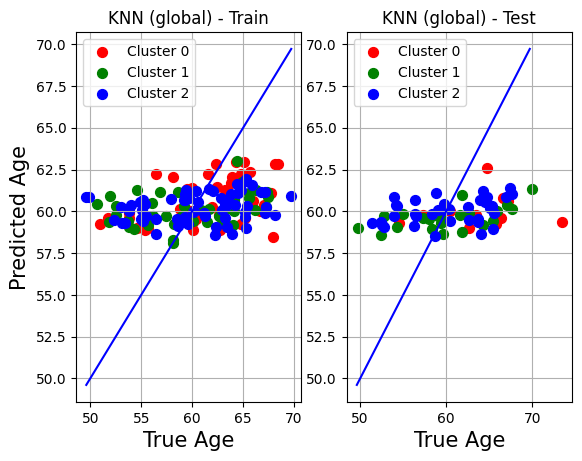

In [42]:
#Create DataFrame for the results
results_raw_global = pd.DataFrame(columns=["Best score", "Train R2",  "Test R2", "Train MAE", "Test MAE"])

#Test for each model
for model_name in models:
    results_raw_global.loc[model_name] = train_model(
        model_name + ' (global)',
        models[model_name],
        raw_train_scaled,
        raw_test_scaled,
        y_train,
        y_test
    )
    
results_raw_global = results_raw_global.style.set_caption('Global')

In [43]:
results_raw_global

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.124394,0.455230,0.255187,2.479697,3.673067
ElasticNet,0.163528,0.460401,0.252490,2.797216,3.649395
AdaBoost,0.080998,0.812419,0.067168,1.846920,4.215311
RandomForest,0.105568,0.838637,0.102987,1.519261,4.148001
KNN,-0.010658,0.089997,0.062985,3.705045,4.224930


C:\Users\anton\AppData\Local\Temp\ipykernel_3092\18067178.py:4: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
C:\Users\anton\AppData\Local\Temp\ipykernel_3092\18067178.py:13: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(
C:\Users\anton\AppData\Local\Temp\ipykernel_3092\18067178.py:22: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.kdeplot(


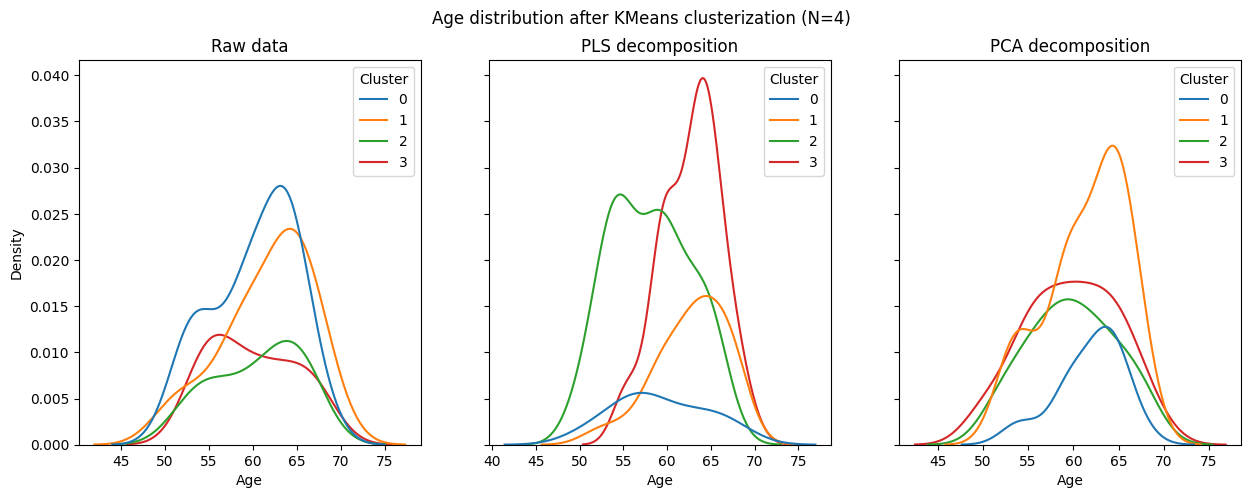

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Age distribution after KMeans clusterization (N=4)')

sns.kdeplot(
    pd.concat([y_train, raw_train_scaled], axis=1, join='inner'),
    x='Age',
    ax=axes[0],
    hue='Cluster',
    palette=sns.color_palette("tab10")
)
axes[0].set_title("Raw data")

sns.kdeplot(
    pd.concat([y_train, pls_train_scaled], axis=1, join='inner'),
    x='Age',
    ax=axes[1],
    hue='Cluster',
    palette=sns.color_palette("tab10")
)
axes[1].set_title("PLS decomposition")

sns.kdeplot(
    pd.concat([y_train, pc_train_scaled], axis=1, join='inner'),
    x='Age',
    ax=axes[2],
    hue='Cluster',
    palette=sns.color_palette("tab10")
)
axes[2].set_title("PCA decomposition")


plt.show()